In [24]:
import alborex_functions
import alborexdata
import netCDF4
import glob
import os
import json
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap 
from geopy.distance import vincenty
import numpy as np
import datetime
from importlib import reload
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

## Configuration

In [25]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)

In [26]:
logger = alborexdata.configure_logging("./logs/alborexFigure6.log")

In [27]:
figdir = config["figdir"]
figname = "thermosal_timeseries"
thermosalfile = config["datafiles"]["thermosal"]
ctdfile = config["datafiles"]["ctd"]

### Projection and colors

In [28]:
m = Basemap(llcrnrlon=-1, llcrnrlat=36.5999, 
            urcrnrlon=-.3, urcrnrlat=37.2, 
            projection='merc', resolution='c')

In [29]:
color1 = "#6C92EE"
color2 = "#43D26A"
NN = -400

## CTD

In [30]:
ctd = alborexdata.CTD()
ctd.get_from_netcdf(ctdfile)

## Thermosal

In [31]:
thermosal = alborexdata.Thermosal()
thermosal.get_from_netcdf(thermosalfile)

Mask too large/low values for T and S     
(no quality controled performed up to now)

In [32]:
thermosal.temperature = np.ma.masked_greater(thermosal.temperature, 22., copy=True)
thermosal.salinity = np.ma.masked_less(thermosal.salinity, 35., copy=True)

## Various subplots
Try to delimit the different tracks (hard-coded, not very clever for the moment).

In [33]:
N1 = [3650, 5020, 13945, 15000, 17200]
N2 = [4585, 5620, 14620, 15800, 18470]

## Add distance bar 

In [34]:
def get_lat_distref(ax, lon, distref=10., center=.5):
    xmin, xmax = ax.get_xlim()
    xcenter = xmin + center * (xmax - xmin)
    xdiff = xmax - xmin
    dist = vincenty((xmin, lon), (xmax, lon))
    aa = xcenter - xdiff * (distref / dist.kilometers) / 2
    bb = xcenter + xdiff * (distref / dist.kilometers) / 2
    return aa, bb

## Final plot using Basemap

/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4771: RuntimeWarning: invalid value encountered in greater
  lonsin = np.where(lonsin > lon_0+180, lonsin-360 ,lonsin)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4772: RuntimeWarning: invalid value encountered in less
  lonsin = np.where(lonsin < lon_0-180, lonsin+360 ,lonsin)
/home/ctroupin/Software/PythonEnvs/Diva-python3.6/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:4776: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = len(lonsin)-np.where(londiff>=thresh)[0]


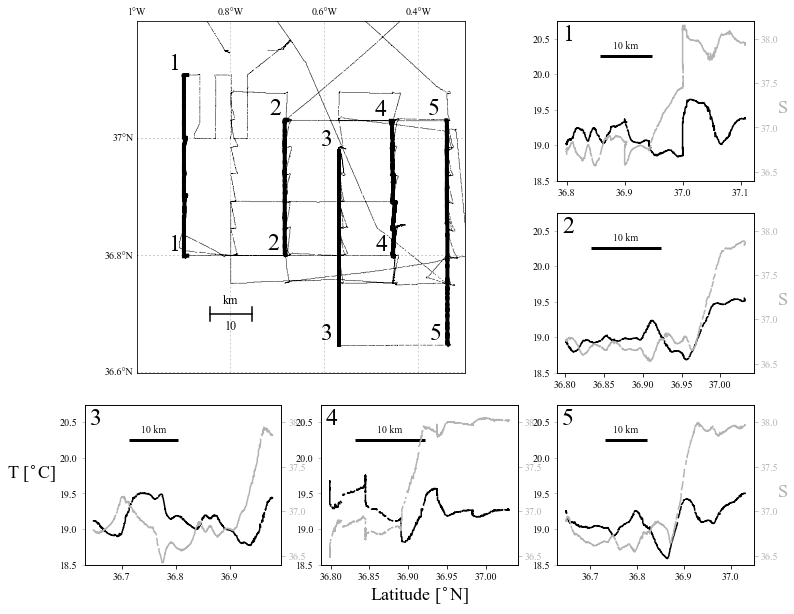

In [37]:
color1 = "k"
color2 = ".7"
plt.figure(figsize=(12, 10))
axloc = ( (0, 2), (1, 2), (2, 0), (2, 1), (2, 2))

# Main map with tracks
ax = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=2)
i = 0
Nind = [0, 1, 2, 4, 3]
Nax = len(Nind)
for nn in Nind:
    i += 1
    m.plot(thermosal.lon[N1[nn]:N2[nn]], thermosal.lat[N1[nn]:N2[nn]], lw=4, zorder=3, color='k', latlon=True)
    xt, yt = m(thermosal.lon[N1[nn]], thermosal.lat[N1[nn]])
    plt.text(xt, yt, str(i) + ' ', va="bottom", ha="right", color='k', fontsize=24)
    xt, yt = m(thermosal.lon[N2[nn]-1], thermosal.lat[N2[nn]-1])
    plt.text(xt, yt, str(i) + ' ', va="bottom", ha="right", color='k', fontsize=24)
m.plot(thermosal.lon[:NN], thermosal.lat[:NN], 'k-', ms=.5, lw=.5, zorder=2, latlon=True)
m.drawparallels(np.arange(36.6, 37.201, 0.2), labels=[1, 0, 0, 0], linewidth=.2)
m.drawmeridians(np.arange(-1., -0.3, 0.2), labels=[0, 0, 1, 0], linewidth=.2)
m.drawmapscale(-.8, 36.7, .8, 36.7, 10, barstyle='simple', units='km', fontsize=12)

# Subplots
for i, nn in enumerate(Nind):
    ax = plt.subplot2grid((3, 3), axloc[i], rowspan=1, colspan=1)
    ax.plot(thermosal.lat[N1[nn]:N2[nn]], thermosal.temperature[N1[nn]:N2[nn]], 
            "-", color=color1)
    aa, bb = get_lat_distref(ax, np.nanmean(thermosal.lon[N1[nn]:N2[nn]]), 
                             distref=10., center=.35)
    ax.hlines(20.25, aa, bb, colors='k', linestyles='solid', label='10 km', linewidth=3)
    plt.text(.5  * (aa + bb), 20.35, "10 km", ha="center")
    plt.text(.025, .98, str(i+1), transform=ax.transAxes, 
             color='k', fontsize=24, ha='left', va='top')
    if i > Nax:
        ax.set_yticklabels(" ")
    if i == 2:
        ax.set_ylabel("T [$^{\circ}$C]", rotation=0, ha="right", fontsize=18, color=color1)
    if i == 3:
        ax.set_xlabel("Latitude [$^{\circ}$N]", fontsize=18, color=color1)
    ax.set_ylim(18.5, 20.75)
    ax.tick_params('y', colors=color1, color=color2)
    ax2 = ax.twinx()
    ax2.plot(thermosal.lat[N1[nn]:N2[nn]], thermosal.salinity[N1[nn]:N2[nn]], "-", color=color2)
    if i > Nax:
        ax2.set_yticklabels(" ")
    if i in (0, 1, 4):
        ax2.set_ylabel("S", rotation=0, fontsize=18, color=color2)
    ax2.set_ylim(36.4, 38.2)
    ax2.tick_params('y', colors=color2)
# plt.savefig(os.path.join(figdir, figname), dpi=300, bbox_inches='tight')
plt.show()
plt.close()